<a href="https://colab.research.google.com/github/sbogde/scikit-regressions-and-confessions/blob/main/week3_06_svr_kc_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [175]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [176]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [177]:
# Check if running in Google Colab (ensure the notebook is file-system agnostic)
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive')
    file_path = '/content/drive/My Drive/Colab Notebooks/kc_house_data.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './kc_house_data.csv'  # Local path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
# Read the dataset from the specified file path into a pandas DataFrame
data = pd.read_csv(file_path)

In [179]:
# Display the first 5 rows of the dataset to understand its structure and content
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [180]:
# Check and handle missing values:
data.isnull().sum()

,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
grade,0
sqft_above,0
sqft_basement,0
yr_built,0


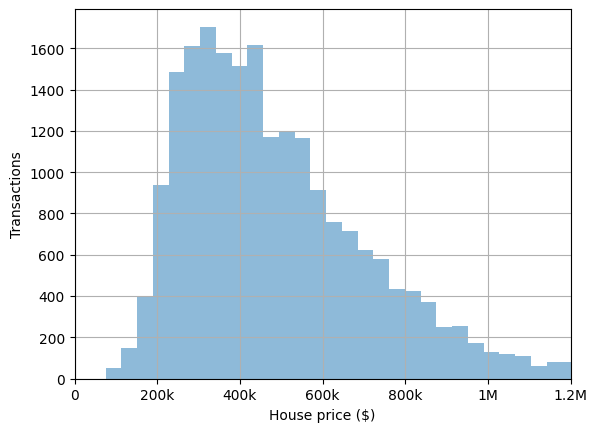

In [181]:
# Histogram of sale prices
plt.hist(data['price'], bins=200, alpha=0.5)
plt.grid()
plt.xlabel('House price ($)')
plt.ylabel('Transactions')
plt.xticks(ticks=[0, 200000, 400000, 600000, 800000, 1000000, 1200000],
           labels=['0', '200k', '400k', '600k', '800k', '1M', '1.2M'])

plt.xlim(0,1200000)
plt.show()

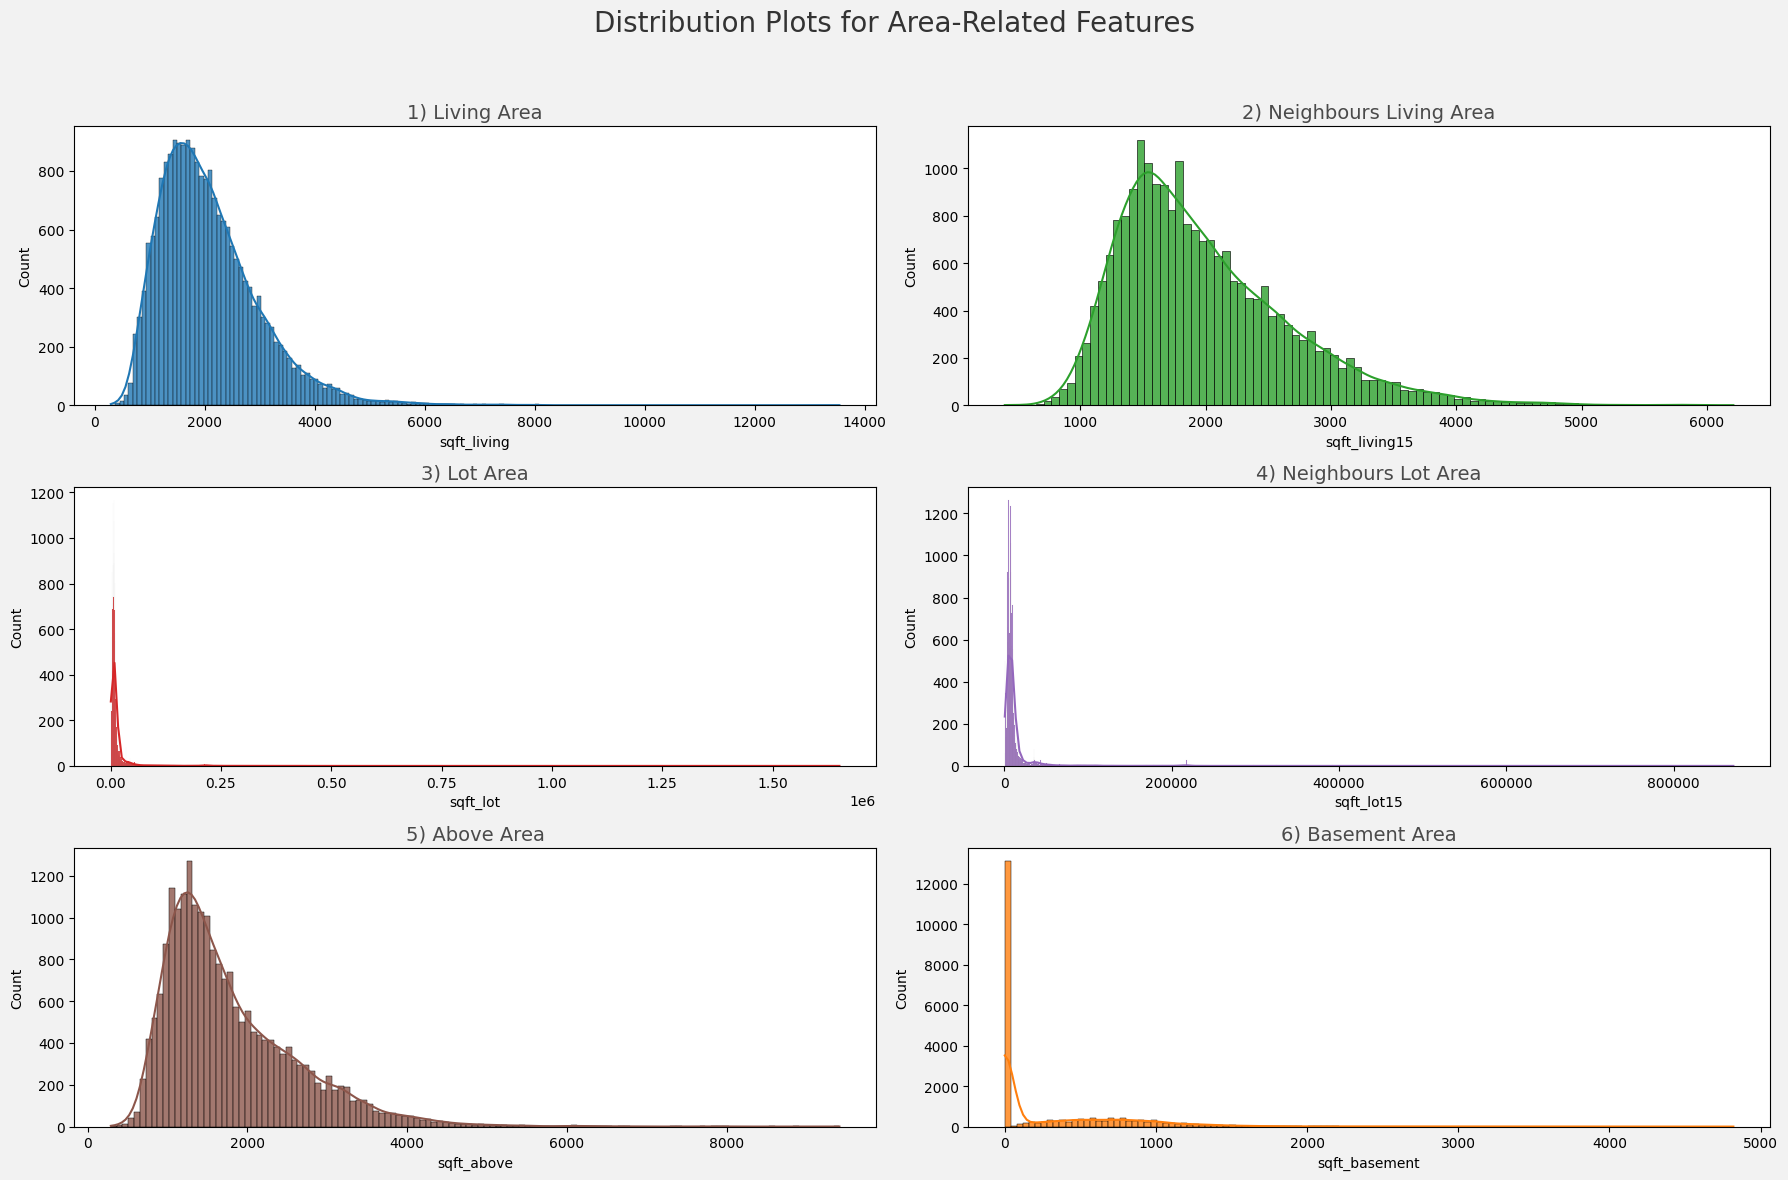

In [182]:
# Define groups of columns based on their characteristics
columns_area = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above', 'sqft_basement']
columns_year = ['yr_renovated', 'yr_built']
columns_room = ['bathrooms', 'bedrooms', 'floors']
columns_rate = ['grade', 'view', 'waterfront', 'condition']
titles_area = ['Living Area', 'Neighbours Living Area', 'Lot Area', 'Neighbours Lot Area', 'Above Area', 'Basement Area']
titles_year = ['Renovated Year', 'Built Year']
titles_rate = ['Grade Rate', 'View Rate', 'Waterfront Rate', 'Condition Rate']

# Colour palette for visualisation
my_colors = ['#FF7F0E', '#1F77B4', '#2CA02C', '#D62728', '#9467BD', '#8C564B']

# Set the columns and titles for plotting (e.g., for area-related features)
columns = columns_area
titles = titles_area

# Calculate the number of columns and rows for the subplots
num_cols = len(columns)
num_rows = math.ceil(num_cols / 2)  # Arrange subplots in two rows for better readability

# Create a figure for the subplots
plt.figure(figsize=(18, 12), facecolor='#F2F2F2')  # Light grey background for better contrast

# Loop through each feature in the group and plot its distribution
for i, (column, title) in enumerate(zip(columns, titles), 1):
    plt.subplot(int(num_rows), 2, i)  # Create a subplot for each feature
    plt.title(f'{i}) {title}', color='#4A4A4A', fontsize=14)  # Add title with dark grey text
    sns.histplot(data[column], kde=True, color=my_colors[i % len(my_colors)], alpha=0.8)  # Add histogram with smooth curve

# Add a main title for the entire figure
plt.suptitle('Distribution Plots for Area-Related Features', color='#333333', size=20)

# Adjust layout to avoid overlapping of plots and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


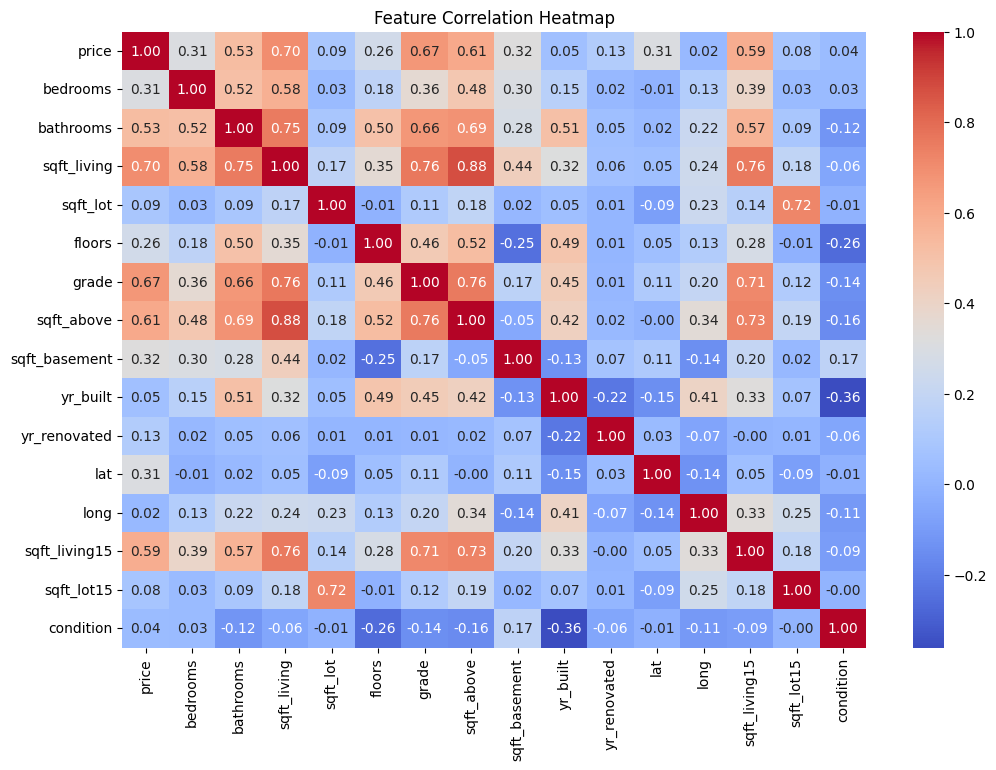

In [183]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") # 'fmt=".2f"' ensures values are shown with 2 decimals for consistency
plt.title("Feature Correlation Heatmap")
plt.show()

In [184]:
# Compute the correlation of all features with the target variable 'price' and sort them in descending order
# This helps identify features that have the strongest positive or negative linear relationship with 'price'
# Features with higher correlation values are more likely to contribute significantly to the model
data.corr()['price'].sort_values(ascending=False)

,price
price,1.000000
sqft_living,0.702044
grade,0.667463
sqft_above,0.605566
sqft_living15,0.585374
bathrooms,0.525134
sqft_basement,0.323837
bedrooms,0.308338
lat,0.306919
floors,0.256786


In [185]:
# Importing Plotly Express for creating interactive visualisations
import plotly.express as px

# Filter the dataset to include only properties with a high grade (grade >= 9)
high_grade_properties = data[data.grade >= 9]

fig = px.scatter_mapbox(
    data_frame=high_grade_properties,
    lat='lat',
    lon='long',
    zoom=10,
    height=500,
    hover_data={'price': True, 'grade': True, 'yr_built': True},
)

# Set the map style to "open-street-map" for a clean and familiar layout
fig.update_layout(mapbox_style="open-street-map")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [186]:
# Drop irrelevant or weakly correlated features
X = data.drop(columns=['price', 'sqft_lot', 'sqft_lot15', 'lat', 'long'])

y = data['price']  # Target variable

In [187]:
# One-Hot Encode categorical columns
# Convert the 'condition' and 'grade' categorical columns into one-hot encoded columns
X = pd.get_dummies(X, columns=['condition', 'grade'], drop_first=True)

# Check the resulting dataset
X.head()

,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,condition_2,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,3,1.00,1180,1.0,1180,0,1955,0,1340,False,...,False,False,False,True,False,False,False,False,False,False
1,3,2.25,2570,2.0,2170,400,1951,1991,1690,False,...,False,False,False,True,False,False,False,False,False,False
2,2,1.00,770,1.0,770,0,1933,0,2720,False,...,False,False,True,False,False,False,False,False,False,False
3,4,3.00,1960,1.0,1050,910,1965,0,1360,False,...,False,False,False,True,False,False,False,False,False,False
4,3,2.00,1680,1.0,1680,0,1987,0,1800,False,...,False,False,False,False,True,False,False,False,False,False


In [188]:
from sklearn.preprocessing import StandardScaler

# Initialise separate scalers for features (X) and target (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale the feature matrix (X) as it ensures all features are on a similar scale, improving model performance
X_scaled = scaler_X.fit_transform(X)

# Reshaping y to 2D ensures compatibility with StandardScaler
y_reshaped = y.values.reshape(-1, 1)
# Scale the target variable (y)
y_scaled = np.ravel(scaler_y.fit_transform(y_reshaped))

In [189]:
# Split data into 80% training and 20% testing, and use 'random_state=42' for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [190]:
# Initialise SVR with RBF kernel

# regressor = SVR(kernel='linear') #0.5929
# regressor = SVR(kernel='poly') #0.5210
# regressor = SVR(kernel='sigmoid') #-0.059

# regressor = SVR(kernel='rbf') #0.6557
# regressor = SVR(kernel='rbf', C=5) #0.6618
# regressor = SVR(kernel='rbf', C=5, epsilon=0.2) #0.6648
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3) #0.6673
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma='auto') #0.6669
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma=0.01) #0.6974
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma=0.011) #0.6981
regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma=0.012) #0.6985
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma=0.013) #0.6982
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma=0.015) #0.6971
# regressor = SVR(kernel='rbf', C=5, epsilon=0.3, gamma=0.005) #0.6893
# regressor = SVR(kernel='rbf', C=5, epsilon=0.4) #0.6664
# regressor = SVR(kernel='rbf', C=5, epsilon=0.5) #0.6651
# regressor = SVR(kernel='rbf', C=6) #0.6581
# regressor = SVR(kernel='rbf', C=10) #0.6470
# regressor = SVR(kernel='rbf', C=12) #0.6419

# Fit the model
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

MAE: 0.3518340829932796
MSE: 0.3381178086702242
R²: 0.6985321250291507


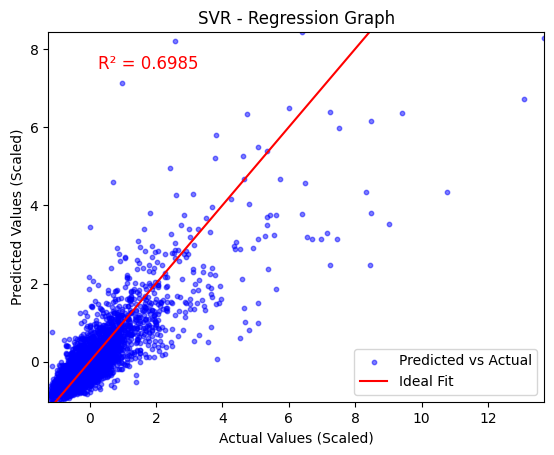

In [191]:
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, color="b", label="Predicted vs Actual", alpha=0.5, s=10)

# Add a red line representing perfect predictions (diagonal line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="r", label="Ideal Fit")

plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_pred.min(), y_pred.max())

plt.text(0.1, 0.9, f"R² = {r2:.4f}", transform=plt.gca().transAxes, fontsize=12, color="red")

# Add labels and title
plt.title("SVR - Regression Graph")
plt.xlabel("Actual Values (Scaled)")
plt.ylabel("Predicted Values (Scaled)")
plt.legend(loc='lower right')

# Display the plot
plt.show()